In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import math
from datetime import date
from statistics import mean
from math import sqrt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import neural_network
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option("display.max_rows", 144, "display.max_columns", 100)
# pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

def p(s):
    print(s)
    
pd.DataFrame.len = pd.Index.len = lambda x: print(len(x))

In [2]:
# Common function definitions
def printStats(y_dev, y_pred):
    # Graph
    plt.scatter(y_dev, y_pred)
    plt.plot(y_pred,y_pred,color='black')
    plt.show()
    
    # Stats
    mae = mean_absolute_error(y_dev, y_pred).round(1)
    rmse = round(math.sqrt(mean_squared_error(y_dev, y_pred)),1)
    r2 = r2_score(y_dev, y_pred).round(2)
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'R^2: {r2}')
    
def cvGrid(params):
    names = ['param_' + x for x in list(params.keys())]
    return pd.DataFrame(grid.cv_results_)[names+['mean_test_score','std_test_score','rank_test_score','mean_fit_time','mean_score_time','std_fit_time','std_score_time']].sort_values(names)


In [3]:
# Partition training, dev, and test data
seasonAndGame = pd.read_csv('../seasonAndGame.csv')
X = seasonAndGame \
    .loc[:,seasonAndGame.columns.str.contains('-\d+') | seasonAndGame.columns.str.match('fanPts')] \
    .drop('fanPts',axis=1) \
    .fillna(0)
y = seasonAndGame.fanPts

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_dev_raw, X_test_raw, y_dev, y_test = train_test_split(X_test_raw, y_test, test_size=0.5, random_state=0)

# Scale
ss = preprocessing.StandardScaler()
X_train_std = pd.DataFrame(ss.fit_transform(X_train_raw), columns=X_train_raw.columns)
X_dev_std = pd.DataFrame(ss.fit_transform(X_dev_raw), columns=X_dev_raw.columns)
X_test_std = pd.DataFrame(ss.fit_transform(X_test_raw), columns=X_test_raw.columns)

# Manually downselect useful columns
keepCols = \
    X.columns.str.contains('fanPts') | \
    X.columns.str.contains('^complete_pass') | \
    X.columns.str.contains('rush_attempt') | \
    X.columns.str.contains('yards_gained') | \
    X.columns.str.contains('^touchdown')

X_train_select, X_dev_select, X_test_select = X_train_raw.loc[:,keepCols], X_dev_raw.loc[:,keepCols], X_test_raw.loc[:,keepCols]
X_train_std_select, X_dev_std_select, X_test_std_select = X_train_std.loc[:,keepCols], X_dev_std.loc[:,keepCols], X_test_std.loc[:,keepCols]

### Multi-layer Perceptron Regression

#### Base model

C:\Users\mrkawa\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


200 iterations
3 layers


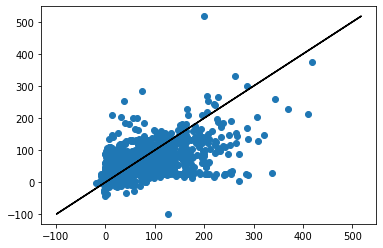

MAE: 33.1
RMSE: 50.1
R^2: 0.38


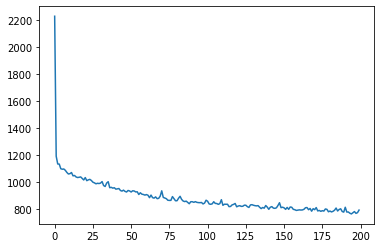

In [4]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

m = neural_network.MLPRegressor()
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

print(f'{m.n_iter_} iterations')
print(f'{m.n_layers_} layers')

printStats(y_dev, y_pred)

plt.plot(m.loss_curve_)

#### GridSearchCV, standardized

Fitting 5 folds for each of 156 candidates, totalling 780 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3

{'activation': 'relu', 'alpha': 1, 'hidden_layer_sizes': 6, 'solver': 'adam'}
88 iterations
3 layers


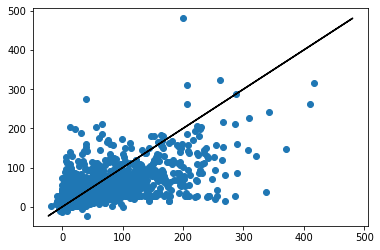

MAE: 32.6
RMSE: 49.7
R^2: 0.39


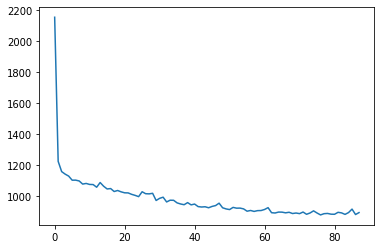

In [5]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

inputNodes = len(X_train.columns)
outputNodes = len(y_train.shape) if y_train.shape == 2 else 1
nSamples = len(X_train)

sizes = [
    mean([inputNodes,outputNodes]),
    (2/3)*inputNodes + outputNodes,
    sqrt(inputNodes*outputNodes),
] + [nSamples/(x*(inputNodes+outputNodes)) for x in range(2,11)] + [x for x in range(2,21)]

params={
    'activation':['relu'],#['identity','logistic','tanh','relu'],
    'solver':['adam'],#['lbfgs','adam'],
    'hidden_layer_sizes': list(set(map(int, sizes))),
    'alpha':[10**x for x in range(-5,1)],
}

grid = GridSearchCV(
    neural_network.MLPRegressor(warm_start=False,random_state=0),
    params,
    n_jobs = -1,
    verbose = 10,
    cv = 5
).fit(X_train,y_train)

print(grid.best_params_)

m = neural_network.MLPRegressor()
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

print(f'{m.n_iter_} iterations')
print(f'{m.n_layers_} layers')

printStats(y_dev, y_pred)

plt.plot(m.loss_curve_)
plt.show()

cvGrid(params).to_csv('raw.csv')

#### GridSearchCV

Fitting 5 folds for each of 168 candidates, totalling 840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   47.0s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3

{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': 248, 'solver': 'adam'}


C:\Users\mrkawa\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


200 iterations
3 layers


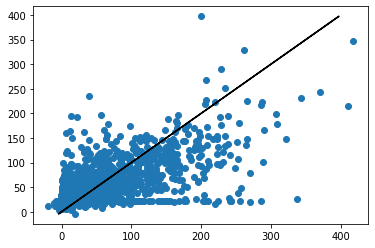

MAE: 31.4
RMSE: 47.0
R^2: 0.46


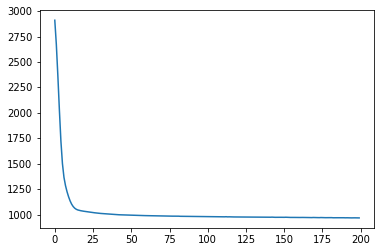

In [7]:
X_train, X_dev, y_train, y_dev = X_train_std_select, X_dev_std_select, y_train, y_dev

inputNodes = len(X_train.columns)
outputNodes = len(y_train.shape) if y_train.shape == 2 else 1
nSamples = len(X_train)

sizes = [
    mean([inputNodes,outputNodes]),
    (2/3)*inputNodes + outputNodes,
    sqrt(inputNodes*outputNodes),
] + [nSamples/(x*(inputNodes+outputNodes)) for x in range(2,11)] + [x for x in range(2,21)]

params={
    'activation':['relu'],#['identity','logistic','tanh','relu'],
    'solver':['adam'],#['lbfgs','adam'],
    'hidden_layer_sizes': list(set(map(int, sizes))),
    'alpha':[10**x for x in range(-5,1)],
}

grid = GridSearchCV(
    neural_network.MLPRegressor(warm_start=False,random_state=0),
    params,
    n_jobs = -1,
    verbose = 10,
    cv = 5
).fit(X_train,y_train)

print(grid.best_params_)

m = neural_network.MLPRegressor()
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

print(f'{m.n_iter_} iterations')
print(f'{m.n_layers_} layers')

printStats(y_dev, y_pred)

plt.plot(m.loss_curve_)
plt.show()

cvGrid(params).to_csv('std.csv')